# One Sample T-test Notebook

Load libraries

In [74]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats import weightstats as statsmodelsweightstats
%matplotlib inline

from collections import Counter

Load data

I will be using a sample dataset.

In [75]:
data = pd.read_excel("student_t_test/data/t-test2.xls", sheet_name ="One-sample t-test")
data.head()

,Scores
0,78
1,83
2,68
3,72
4,88


In [76]:
#Summary
data.describe()

,Scores
count,20.000000
mean,70.150000
std,10.912451
min,50.000000
25%,64.250000
50%,70.500000
75%,75.000000
max,90.000000


# Important Variables
So, we have performance scores of kids in a certain game.

# Question
Is there a statistically significant difference between the sample mean from 79 ?

# hypothesis 
H0: There's no difference between the sample mean from 79  
Ha: There's a statistically significant difference between the sample mean from 79 


# The alpha level will be 0.05.
alpha = 0.05


# Assumptions
Determine if data meets requirements to perform an one samples t-test.


Assumption #1: Your Test variable should be measured on a continuous scale.      
Assumption #2: You should have dependence of observations.    
Assumption #3: There should be no significant outliers.    
Assumption #4: Your dependent variables should be approximately normally distributed.    
Assumption #5: There needs to be homogeneity of variances.

# Check missing values

In [77]:
#Lets Look At Missing Data
total = data.isnull().sum().sort_values(ascending=False)
percent_1 = data.isnull().sum()/data.isnull().count()*100
percent_2 = (round(percent_1, 1)).sort_values(ascending=False)
missing_data = pd.concat([total, percent_2], axis=1, keys=['Total Missing', '%'])
missing_data.loc[missing_data['Total Missing'] > 0].head()

,Total Missing,%


Okay, we don't have missing values



# Check and Remove significant outliers

In [78]:
def detect_outliers(df, n, features):
        """
        Takes a dataframe df of features and returns a list of the indices
        corresponding to the observations containing more than n outliers according
        to the Tukey method.
        """
        outlier_indices = []

        # iterate over features(columns)
        for col in features:
            # 1st quartile (25%)
            Q1 = np.percentile(df[col], 25)
            # 3rd quartile (75%)
            Q3 = np.percentile(df[col],75)
            # Interquartile range (IQR)
            IQR = Q3 - Q1

            # outlier step
            outlier_step = 1.5 * IQR

            # Determine a list of indices of outliers for feature col
            outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index

            # append the found outlier indices for col to the list of outlier indices
            outlier_indices.extend(outlier_list_col)

        # select observations containing more than 2 outliers
        outlier_indices = Counter(outlier_indices)
        multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )

        return multiple_outliers

In [79]:
#Checking outliers in Scores
detect_outliers(data, 0, ['Scores'])

[]

Again we have significant outliers. Lets check that with boxplot

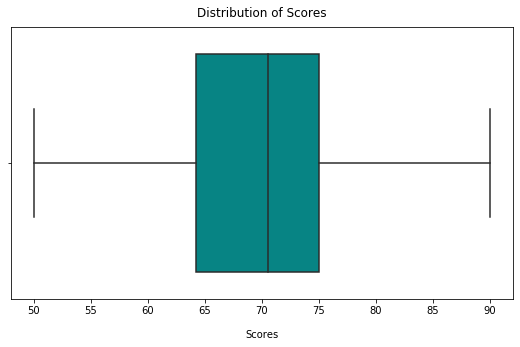

In [80]:
plt.figure(figsize=(9, 5))
sns.boxplot(data['Scores'], color='darkcyan', saturation=0.9)
plt.title("Distribution of Scores", y=1.015)
plt.xlabel("Scores", labelpad=14);

# Normality Law


Visualize distribution and use Shapiro-Wilk test to check normality

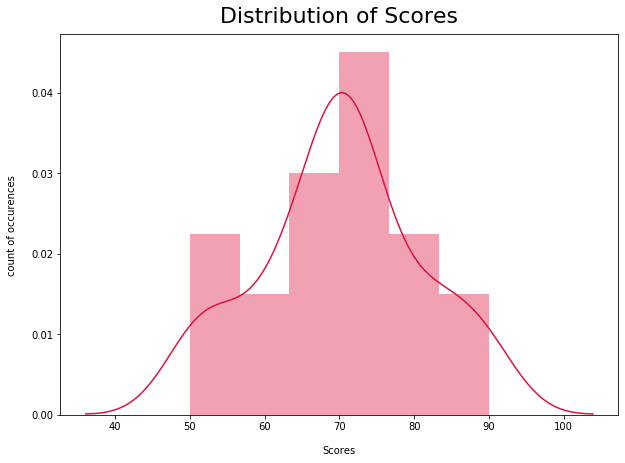

In [81]:
plt.figure(figsize=(10, 7))
sns.distplot(data['Scores'], color='crimson')
plt.title("Distribution of Scores", y=1.015, fontsize=22)
plt.xlabel("Scores", labelpad=14)
plt.ylabel("count of occurences", labelpad=14);

In [82]:
# Shapiro-Wilk normality test for Scores
stats.shapiro(data.Scores.dropna())

(0.9715325236320496, 0.786862313747406)

Shapiro-Wilk test for normality was not significant which indicates that the scores are normally distibuted.

# One Sample T-test

In [83]:
t_statistic, p = stats.ttest_1samp(data.Scores, 79.00)
print('T statistic : {}'.format(t))
print('P value : {}'.format(p))

T statistic : -3.626903297092919
P value : 0.0017951020521526587


# Interpretation


The p value returned (0.0018) is lower than threshold 'a' (0.05). Thus the null hypothesis is rejected and we argue that sample mean score of 70.15±10.91 is significantly different (lower) compared to the general mean score of 79.00 for this test in the past. 


The average score of the sample is about 8.85 units lower than the overall hypothesized average.

Is it tough to determine if this value of 8.85 is considered small or large?. The sample standard deviation is 10.91 so I think this difference in means of 8.85 at a glance seems relatively large. To combat this uncertainty of the calculation above, we can use the measure of Cohen's d

# Cohen's d
Cohen's d is a measure to determine the standardized mean difference in groups. The measure is the difference in group means in terms of standard deviation units.

In [84]:
sample_mean = np.mean(data.Scores)
sample_standard_deviation = np.std(data.Scores)
population_mean = 79.00
population_standard_deviation = 5.00

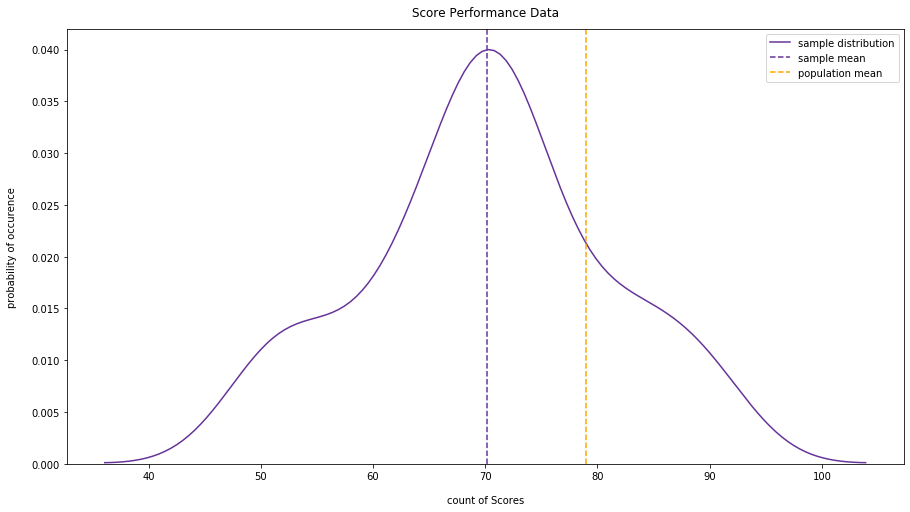

In [85]:
plt.figure(figsize=(15, 8))
sns.distplot(data.Scores, hist=False, label='sample distribution', color='rebeccapurple')
plt.axvline(x=sample_mean, color='rebeccapurple', linestyle='--', label="sample mean")
plt.axvline(x=population_mean, color='orange', linestyle='--', label='population mean')
plt.xlabel("count of Scores", labelpad=14)
plt.ylabel("probability of occurence", labelpad=14)
plt.title("Score Performance Data", y=1.015)
plt.legend();

# Cohen's d Interpretation

In [86]:
def interpret_cohens_d(cohens_d):
    """
    Determines text interpretation of effect size given Cohen's d value

    :param cohens_d: float of Cohen's d value
    :returns: effect_size_interpretation: adjective to describe magnitude of effect size
    """
    if 0<=cohens_d<0.1:
        effect_size_interpretation = "Very Small"
    elif 0.1<=cohens_d<0.35:
        effect_size_interpretation = "Small"
    elif 0.35<=cohens_d<0.65:
        effect_size_interpretation = "Medium"
    elif 0.65<=cohens_d<0.9:
        effect_size_interpretation = "Large"
    elif cohens_d >= 0.9:
        effect_size_interpretation = "Very Large"
    return effect_size_interpretation

In [87]:
def two_sample_data_setup_for_cohens_d(mean_1, mean_2, sample_std_dev_1, sample_std_dev_2):
    """
    Creates two normal distributions of data values. 
    Calculates differences in values and standard deviation of list of differences.
    Calculates Cohen's D - equation used in dependent t-tests

    :param mean_1: mean of group one
    :param mean_2: mean of group two
    :param sample_std_dev_1: sample standard deviation of group one
    :param sample_std_dev_2: sample standard deviation of group two
    
    :returns: values_1, values_2, cohens_d: values for group one, values for group two, Cohen's d
    """
    values_1 = np.random.normal(loc=mean_1, scale=sample_std_dev_1, size=3000)
    values_2 = np.random.normal(loc=mean_2, scale=sample_std_dev_2, size=3000)
    differences_group_values = np.subtract(values_1, values_2)
    std_dev_differences_group_values = np.std(differences_group_values, ddof=1)
    cohens_d = round(abs((mean_1 - mean_2)/std_dev_differences_group_values), 2)
    return values_1, values_2, cohens_d

In [88]:
def visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation):
    """
    Plots KDE plots of values from values_1 and values_2.
    Inserts Cohen's d value and interpretation in title

    :param values_1: values in group one
    :param values_2: values in group two 
    :param cohens_d: Cohen's d value
    :param cohens_d_interpretation: text to describe magnitude of effect size
    :returns: plot figure
    """
    plt.figure(figsize=(10, 8))
    sns.distplot(values_1, hist=False)
    sns.distplot(values_2, hist=False)
    plt.xlabel("value", labelpad=13)
    plt.ylabel("frequency", labelpad=13)
    plt.title("Distribution of Two Groups with {0} Cohen's d of {1}".format(cohens_d_interpretation, cohens_d), y=1.015, fontsize=22);

In [89]:
two_groups_close_means_small_std_dev = two_sample_data_setup_for_cohens_d(sample_mean, population_mean, sample_standard_deviation, population_standard_deviation)
values_1 = two_groups_close_means_small_std_dev[0]
values_2 = two_groups_close_means_small_std_dev[1]
cohens_d = two_groups_close_means_small_std_dev[2]
cohens_d_interpretation = interpret_cohens_d(cohens_d)

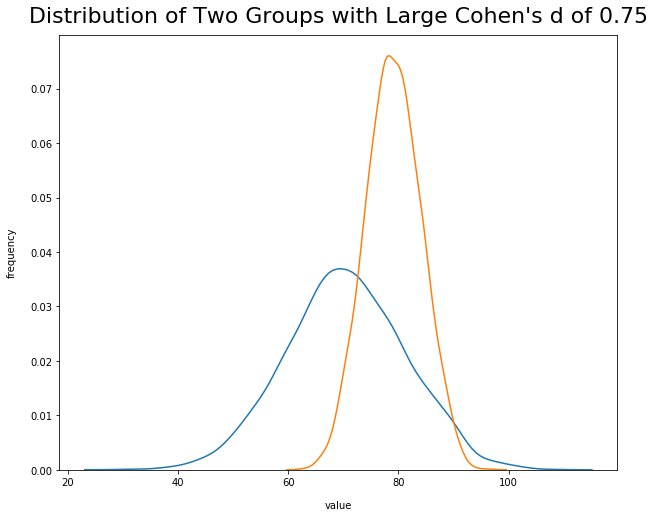

In [90]:
visualize_distributions(values_1, values_2, cohens_d, cohens_d_interpretation)

There's a 0.75 difference in means in terms of sample standard deviation units. The larger the Cohen's d value, the further sample means are from one another in standard deviation units.

In [91]:
print('The Effect size is '+str(interpret_cohens_d(0.75)))

The Effect size is Large


As seen above, the small Cohen's d value of 0.75 means that the sample means are far from one another in standard deviation units.